<h1>Training Code<h1>

In [1]:
!pip install tensorflow==2.10.1

In [2]:
!pip install n2v

  Using cached n2v-0.3.3-py2.py3-none-any.whl (48 kB)
  Using cached imagecodecs-2024.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.5 MB)
  Using cached csbdeep-0.7.4-py2.py3-none-any.whl (69 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 26.6 MB/s eta 0:00:00
  Created 

In [3]:
import tensorflow as tf
import n2v
print(tf.__version__)
print(n2v.__version__)

2.10.1
0.3.3


In [33]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [34]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [35]:
#METHOD 1: Loading images using load_imgs_from_directory method
# We load all the '.png' files from the directory.
# The function will return a list of images (numpy arrays).
imgs = datagen.load_imgs_from_directory(directory = "/content/drive/MyDrive/Colab Notebooks/data/N2V/png_images/Noisy",
                                        filter='skyNOISE*.png',dims='XYC')  #ZYX for 3D

print(len(imgs)) #need to check if function actually got the image

# Let's look at the shape of the image
print('shape of loaded images: ',imgs[0].shape)
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)


2
shape of loaded images:  (1, 985, 690, 3)
shape without alpha:     (1, 985, 690, 3)
The data type of the first image is:  float32


In [36]:
print(len(imgs))
print(imgs[0].shape)
print(imgs[0].dtype)

2
(1, 985, 690, 3)
float32


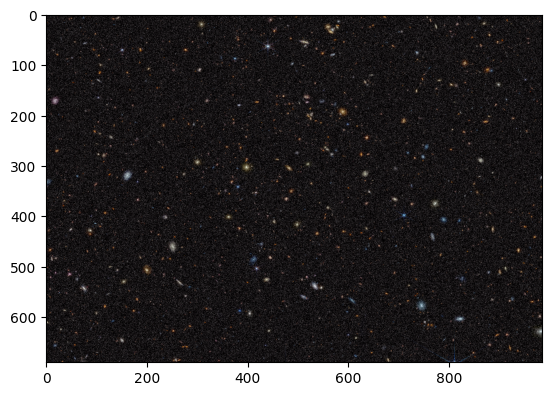

In [37]:
# Let's look at the image.
plt.figure()
plt.imshow(np.rot90(imgs[0][0,:,:,:], k=-1))
plt.show()

In [38]:
patch_size = 64

In [39]:
# Patches are extracted from all images and combined into a single numpy array
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


Generated patches: (1200, 64, 64, 3)
Generated patches: (1200, 64, 64, 3)


In [40]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [41]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(1920, 64, 64, 3)
float32
(480, 64, 64, 3)


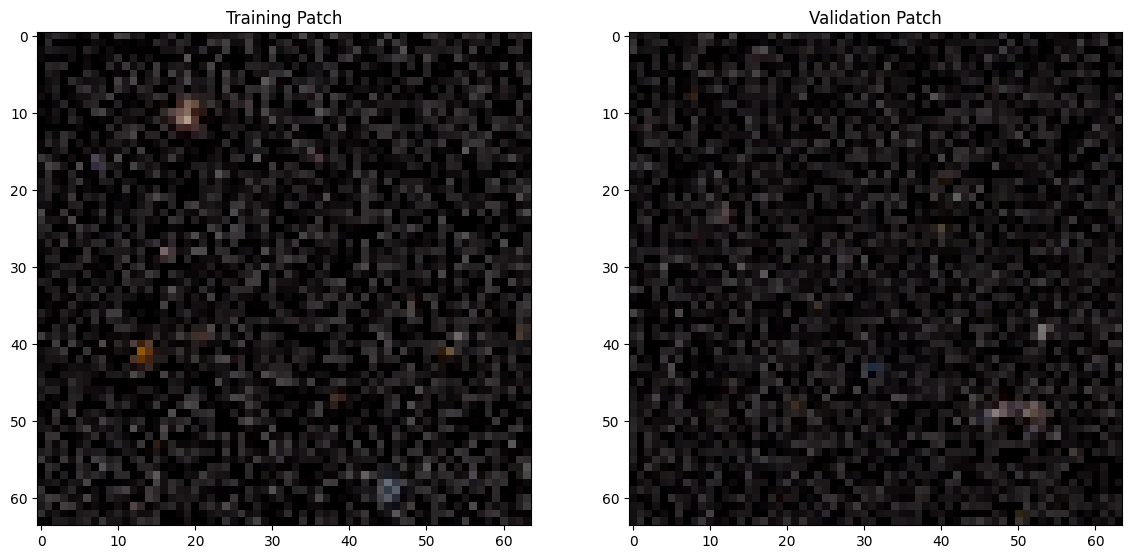

In [42]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

<h2>Configure</h2><p>

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the N2VConfig constructor for a description of all parameters.
<p>
When creating the config-object, we provide the training data X. From X we extract mean and std that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from X.
<p>
Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased train_batch_size and batch_norm. To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter n2v_manipulator with default value 'uniform_withCP'. Most pixel manipulators will compute the replacement value based on a neighborhood. With n2v_neighborhood_radius we can control its size.
<p>
<h3>Other pixel manipulators:</h3>
<p>
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
<br>
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = n2v_neighborhood_radius
<br>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
<br>
* identity: performs no pixel manipulation
<br>
For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via n2v_perc_pix.
<p>
For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).
<p>
In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the single_net_per_channel option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.<br>
Note: Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.
<p>
**Warning:** to make this example notebook execute faster, we have set train_epochs to only 10.
For better results we suggest 100 to 200 train_epochs.

In [53]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch
# is shown once per epoch.
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=50, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['0.09102309', '0.07934603', '0.08312057'],
 'stds': ['0.09114447', '0.08485986', '0.084219724'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 50,
 'train_steps_per_epoch': 60,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [54]:
# a name used to identify the model
model_name = 'n2v_2D_stars'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

In [55]:
# We are ready to start training now.
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 480/480 [00:00<00:00, 1551.16it/s]

Epoch 1/50


60/60 [==============================] - 62s 1s/step - loss: 0.3686 - n2v_mse: 0.3686 - n2v_abs: 0.4168 - val_loss: 0.7532 - val_n2v_mse: 0.7532 - val_n2v_abs: 0.6728 - lr: 4.0000e-04
Epoch 2/50
60/60 [==============================] - 60s 999ms/step - loss: 0.0961 - n2v_mse: 0.0961 - n2v_abs: 0.2213 - val_loss: 0.7926 - val_n2v_mse: 0.7926 - val_n2v_abs: 0.6879 - lr: 4.0000e-04
Epoch 3/50
60/60 [==============================] - 60s 994ms/step - loss: 0.0678 - n2v_mse: 0.0678 - n2v_abs: 0.1841 - val_loss: 0.8178 - val_n2v_mse: 0.8178 - val_n2v_abs: 0.7051 - lr: 4.0000e-04
Epoch 4/50
60/60 [==============================] - 60s 999ms/step - loss: 0.0550 - n2v_mse: 0.0550 - n2v_abs: 0.1646 - val_loss: 0.8581 - val_n2v_mse: 0.8581 - val_n2v_abs: 0.7221 - lr: 4.0000e-04
Epoch 5/50
60/60 [==============================] - 60s 1s/step - loss: 0.0467 - n2v_mse: 0.0467 - n2v_abs: 0.1502 - val_loss: 0.9264 - val_n2v_mse: 0.9264 - val_n2v_abs: 0.7409 - lr: 4.0000e-04
Epoch 6/50
60/60 [=========

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


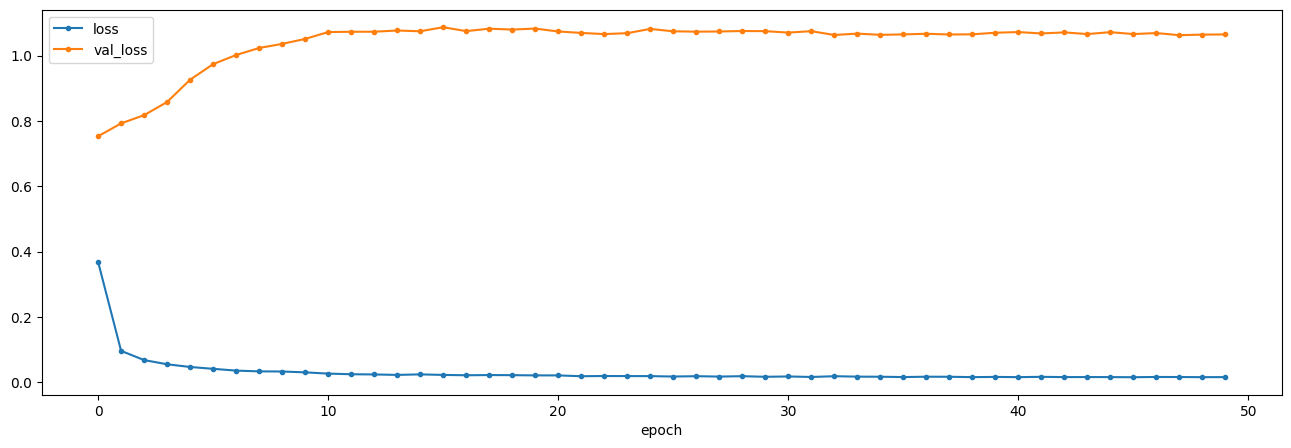

In [56]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

<h1>Prediction / Testing Code<h1>

In [57]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [58]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model_name = 'n2v_2D_stars'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [59]:
# We load the data we want to process.
img = imread('/content/drive/MyDrive/Colab Notebooks/data/N2V/png_images/Noisy/skyNOISE.png')
img.dtype

dtype('float32')

In [60]:

# Here we denoise the image (predict)
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred = model.predict(img, axes='YXC')



1/1 [==============================] - 1s 962ms/step


In [62]:
pred.shape

(690, 985, 3)

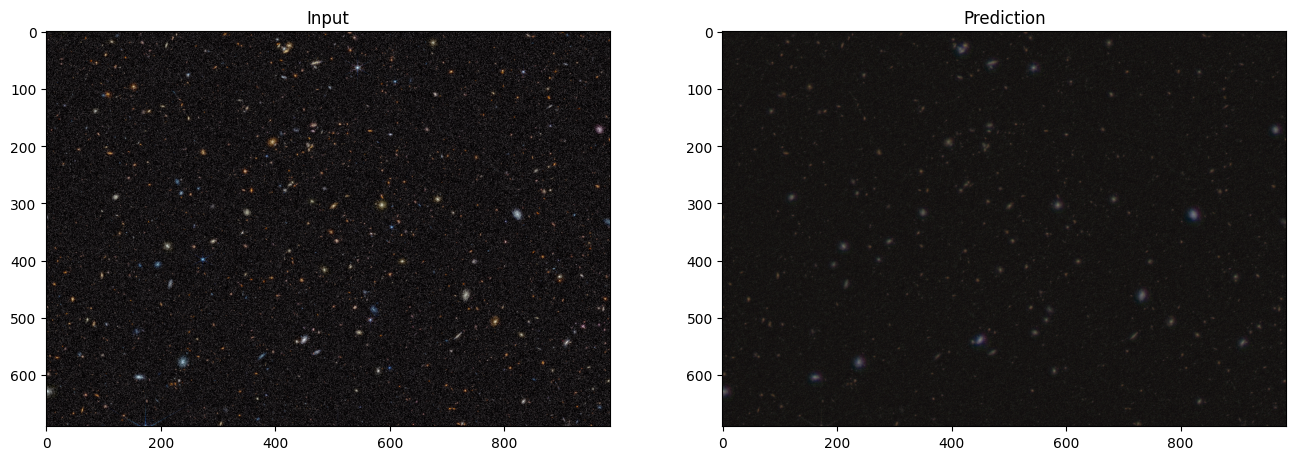

In [63]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction');

In [32]:
save_tiff_imagej_compatible('pred_train.tif', pred, axes='YXC')